In [1]:
from typing import Any

import matplotlib.pyplot as plt
import mlflow
import mlflow.artifacts
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from mlflow.store.entities.paged_list import PagedList
from mlflow.tracking import MlflowClient

from cate.infra.mlflow import REMOTE_TRACKING_URI


In [2]:
experiment_name = "biased_data"

In [3]:
mlflow.set_tracking_uri(REMOTE_TRACKING_URI)
client = MlflowClient(tracking_uri=REMOTE_TRACKING_URI)

In [4]:
experiment = client.search_experiments(filter_string=f"name='{experiment_name}'")[0]

In [5]:
def get_child_runs(parent_run_id) -> PagedList:
    return client.search_runs(
        experiment.experiment_id,
        filter_string=f"tags.mlflow.parentRunId='{parent_run_id}'",
    )

In [12]:
def parse_run(run) -> dict[str, Any]:
    _metrics = run.to_dictionary()["data"]["metrics"]
    _tags = run.to_dictionary()["data"]["tags"]
    metrics_keys = [
        "auuc",
        "uplift_at_10",
        "uplift_at_20",
        "uplift_at_30",
        "uplift_at_40",
        "uplift_at_50",
        "uplift_at_60",
        "uplift_at_70",
        "uplift_at_80",
        "uplift_at_90",
    ]
    tags_keys = ["model", "dataset", "random_ratio", "rank"]
    try:
        return {
            **{k: _metrics[k] for k in metrics_keys},
            **{k: _tags[k] for k in tags_keys},
        }
    except:
        return {}


In [13]:
dataset_names = ("criteo", "lenta", "megafon", "hillstorm")
parent_run_ids = [
    "2792b73fda3142e7a9973110a42c754e",
    "63c2354fbd92494ba4a46af185701ab6",
    "70e68a32689a47528a3034ee1ff920e8",
    "9b386d6ef1fd4804b6376a929ef45723",
]


In [14]:
df = None
for dataset_name, parent_run_id in zip(dataset_names, parent_run_ids):
    runs = get_child_runs(parent_run_id)
    data = [parse_run(run) for run in runs]
    _df = pd.DataFrame(data)
    if df is None:
        df = _df
    else:
        df = pd.concat([df, _df])
df = df.reset_index(drop=True)

In [15]:
df

auuc  uplift_at_10  uplift_at_20  uplift_at_30  uplift_at_40  \
0    0.264745      0.006751      0.003965      0.002860      0.002237   
1    0.205346      0.005719      0.003244      0.002251      0.001752   
2    0.246757      0.006543      0.003739      0.002657      0.002070   
3    0.232646      0.006124      0.003547      0.002526      0.001948   
4    0.186824      0.005296      0.002930      0.002096      0.001616   
..        ...           ...           ...           ...           ...   
716  0.186029      0.005468      0.007219      0.006011      0.003948   
717  0.269837      0.003659      0.006455      0.005791      0.005604   
718  0.427342      0.011383      0.007749      0.004948      0.005291   
719  0.391213      0.009845      0.009881      0.006893      0.004613   
720  0.141314      0.003068      0.002758      0.003376      0.003658   

     uplift_at_50  uplift_at_60  uplift_at_70  uplift_at_80  uplift_at_90  \
0        0.001821      0.001537      0.001318      0.001170      0.001045   
1        0.001425      0.001207      0.001040      0.000922      0.000824   
2        0.001671      0.001405      0.001213      0.001064      0.000955   
3        0.001602      0.001344      0.001159      0.001020      0.000945   
4        0.001332      0.001121      0.000965      0.000852      0.000760   
..            ...           ...           ...           ...           ...   
716      0.003948      0.002630      0.003377      0.004150      0.004332   
717      0.004367      0.004434      0.004212      0.004391      0.004774   
718      0.004879      0.005401      0.005530      0.005260      0.005384   
719      0.004423      0.004673      0.004842      0.005230      0.004107   
720      0.002634      0.002804      0.002846      0.003625      0.004681   

         model    dataset random_ratio rank  
0     tlearner     criteo          1.0    5  
1     tlearner     criteo          0.8    5  
2     tlearner     criteo          0.6    5  
3     tlearner     criteo          0.4    5  
4     tlearner     criteo          0.2    5  
..         ...        ...          ...  ...  
716  drlearner  hillstorm          0.8    5  
717  drlearner  hillstorm          0.6    5  
718  drlearner  hillstorm          0.4    5  
719  drlearner  hillstorm          0.2    5  
720  drlearner  hillstorm          0.0    5  

[721 rows x 14 columns]

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder_model = LabelEncoder()
label_encoder_dataset = LabelEncoder()

encoded_df = df.copy()
encoded_df["model"] = label_encoder_model.fit_transform(df["model"])
encoded_df["dataset"] = label_encoder_dataset.fit_transform(df["dataset"])

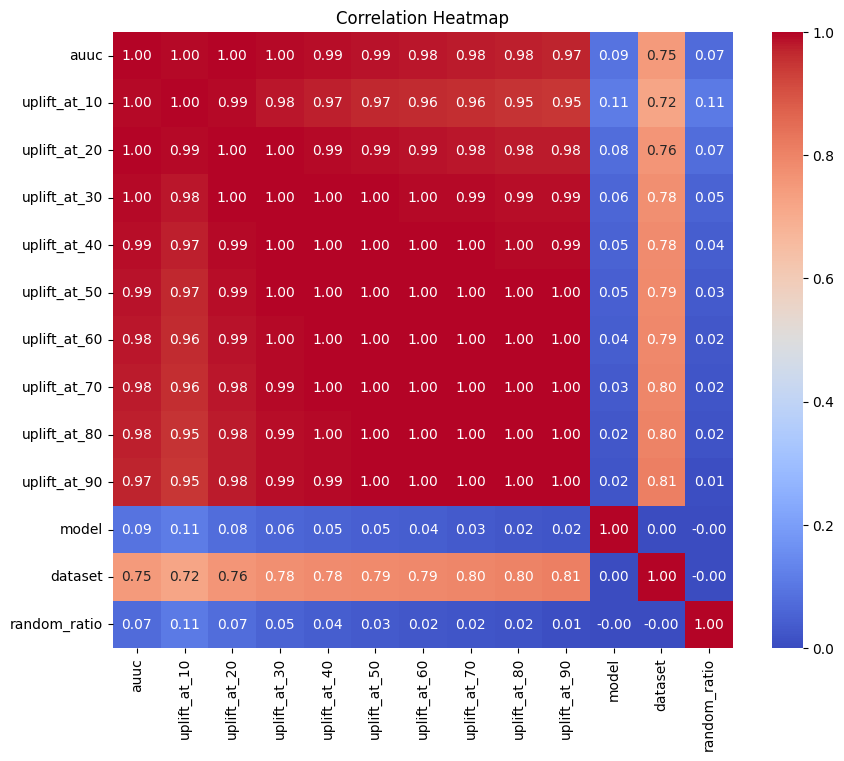

In [10]:
corr = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [17]:
dataset_flg = df["dataset"] == "criteo"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

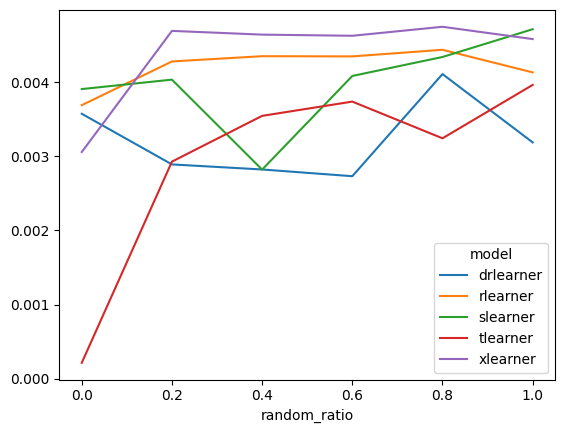

In [18]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

In [20]:
dataset_flg = df["dataset"] == "hillstorm"
rank_flg = df["rank"] == "2"
_df = df.loc[dataset_flg & rank_flg, ["uplift_at_20", "model", "random_ratio"]]

In [21]:
_df

uplift_at_20      model random_ratio
90       0.006251   tlearner          1.0
91       0.006118   tlearner          1.0
92       0.005330   tlearner          1.0
93       0.002148   tlearner          1.0
94       0.004868   tlearner          1.0
..            ...        ...          ...
385      0.009727  drlearner          0.0
386      0.002502  drlearner          0.0
387      0.005670  drlearner          0.0
388      0.006495  drlearner          0.0
389     -0.000514  drlearner          0.0

[300 rows x 3 columns]

In [24]:
_df = _df.groupby(["model", "random_ratio"]).median().reset_index()

<Axes: xlabel='random_ratio'>

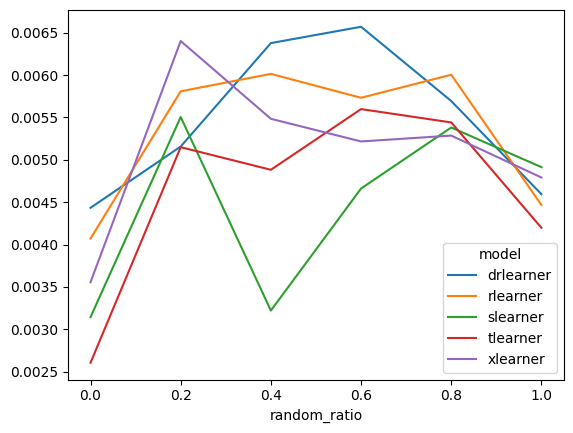

In [25]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

In [23]:
dataset_flg = df["dataset"] == "lenta"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

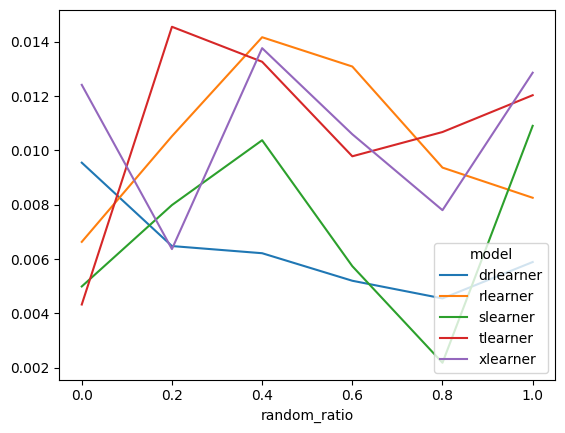

In [24]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()


In [25]:
dataset_flg = df["dataset"] == "megafon"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

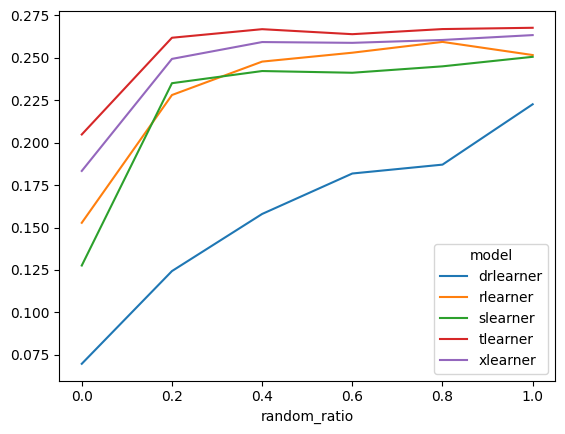

In [26]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()
